# Returning the echo distance

This notebook uses the water tank model from the previous notebook, with a solution to generating source positions and measurement setups and returning a point from the echo.

In [1]:
import math
import os
import time
from enum import Enum
from typing import Tuple

import numpy as np
import numpy.typing as npt
import matplotlib as mpl
import matplotlib.pyplot as plt 
from examples.seismic import Receiver, WaveletSource, RickerSource, Model, TimeAxis,  plot_velocity, plot_shotrecord
from devito import TimeFunction, Eq, solve, Operator, ConditionalDimension
from scipy.signal import find_peaks, peak_prominences
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['figure.figsize'] = (10, 10)  # Increases figure size

## Grid Setup
Set velocity model and global parameters for water tank.

In [2]:
nx = 601
nz = 301
nb = 10
shape = (nx, nz)
spacing = (.1, .1) #60x30 m 
origin = (0., 0.)
v_water = 1.5 # v in distilled water 1496.7 m/s
v_glass = 5.64 # v in glass 5640 m/s
v_obj = 3.24 # v in gold 3240 m/s
glass = 50 # size of the glass
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = v_water
# ellipse formula
# a = (int)((nx - 1) / 2)
# b = (int)((nz - 1) / 2)
# for i in range(nx):
#     for j in range(nz):
#         if ((i - a)**2 / a**2 + (j - b)**2 / b**2) > 1:
#             v[i, j] = v_glass
# v[:, :b] = v_water

# circle formula
r = (int)((nz - 1) / 2)
a, b = (shape[0] - 1) / 2, (shape[1] - 1) / 2
y, x = np.ogrid[-a:shape[0]-a, -b:shape[1]-b]
v[x*x + y*y > r*r] = v_obj


model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nb, bcs="damp")

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


## Define the positions of the sources and receivers

In [3]:
def srcPositions(cx: float, cy:float, alpha:float, ns:int, sdist:float) -> np.typing.NDArray:
    assert alpha >= 0 and alpha < 180
    assert ns > 0
    dx = sdist * math.sin(math.pi / 180 * alpha)
    dy = sdist * math.cos(math.pi / 180 * alpha)

    res = np.zeros((ns, 2))
    res[:, 0] = np.linspace(cx - dx * (ns - 1) / 2, cx + dx * (ns - 1) / 2, num = ns)
    res[:, 1] = np.linspace(cy - dy * (ns - 1) / 2, cy + dy * (ns - 1) / 2, num = ns)
    return res

In [4]:
def srcPositionsInDomain(domain_size: tuple[np.float64, np.float64], posx: float = 0.5, 
                         posy: float = 0.0, source_distance: float = .1, ns: int = 128, 
                         angle: float = 90) -> tuple[np.typing.NDArray, tuple[float, float]]:
    # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
    # posx and posy are relative positions 0 - left, 1 - right (or top-bottom)
    cx = domain_size[0] * posx
    if posy == 0.0:
        cy = (ns - 1) / 2 * source_distance
    else:
        cy = domain_size[1] * posy
    return srcPositions(cx, cy, angle, ns, source_distance), (cx, cy)


In [5]:
class SineSource(WaveletSource):
    @property
    def wavelet(self):
        t0 = self.t0 or 1 / self.f0
        a = self.a or 1
        r = (np.pi * self.f0 * (self.time_values - t0))
        wave = a * np.sin(r) + a*np.sin(3*(r+np.pi)/4)
        wave[np.searchsorted(self.time_values, 4*2/self.f0):] = 0
        return wave

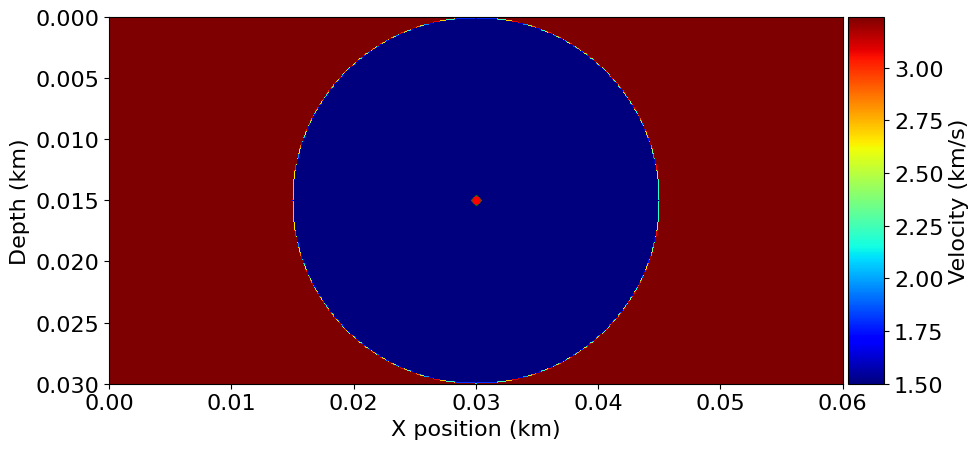

In [6]:
def setup_domain(model, tn=0.05, ns=128, f0=5000, posx=0.5, posy=0.0, angle=90):
    # Set time range, source, source coordinates and receiver coordinates
    t0 = 0.  # Simulation starts a t=0
    # tn - Simulation lasts tn milliseconds
    dt = model.critical_dt  # Time step from model grid spacing
    time_range = TimeAxis(start=t0, stop=tn, step=dt)

    # f0 Source peak frequency is 5 MHz (5000 kHz)
    # ns number of sources
    nr = ns  # number of receivers
    depth = 1
    wavelength = v_water / f0
    source_distance = wavelength / 8
    # angle of the sources to the water surface (0° - 180°) 90° means sources are parallel with the water surface
    source_angle = angle
    # posx and posy are relative positions 0 - left, 1 - right (or top-bottom)
    pos, center_pos = srcPositionsInDomain(model.domain_size,
                                           posx=posx,
                                           posy=posy,
                                           angle=source_angle,
                                           ns=ns,
                                           source_distance=source_distance)
    src = SineSource(
        name='src',
        grid=model.grid,
        f0=f0,
        time_range=time_range,
        npoint=ns)

    src.coordinates.data[:, -1] = depth
    src.coordinates.data[:] = pos[:]

    rec = Receiver(
        name='rec',
        grid=model.grid,
        npoint=nr,
        time_range=time_range)

    rec.coordinates.data[:, -1] = depth
    rec.coordinates.data[:] = pos[:]
    return src, rec, time_range, center_pos, source_distance


source_angle = 90
src, rec, time_range, center_pos, source_distance = setup_domain(
    model, tn=50, ns=1, f0=5, posx=.5, posy=.5, angle=source_angle)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])


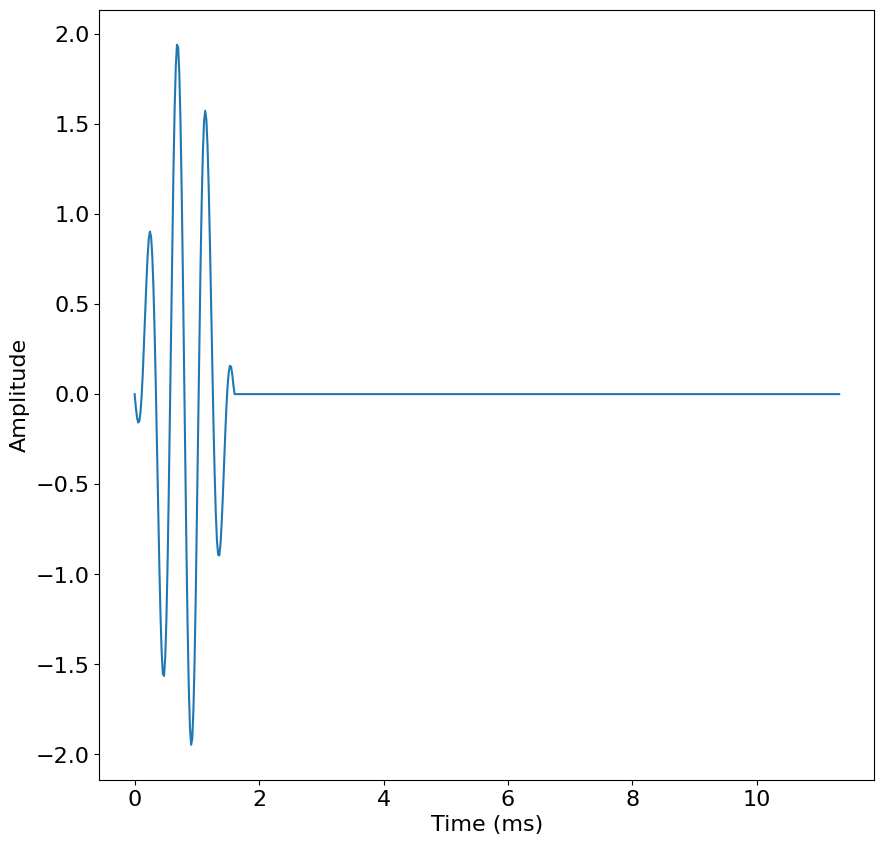

In [7]:
plt.figure()
plt.plot(src.time_values[:600], src.data[:600,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

## Operator and plot velocity profile

Operator `Kernel` ran in 1.11 s


2647


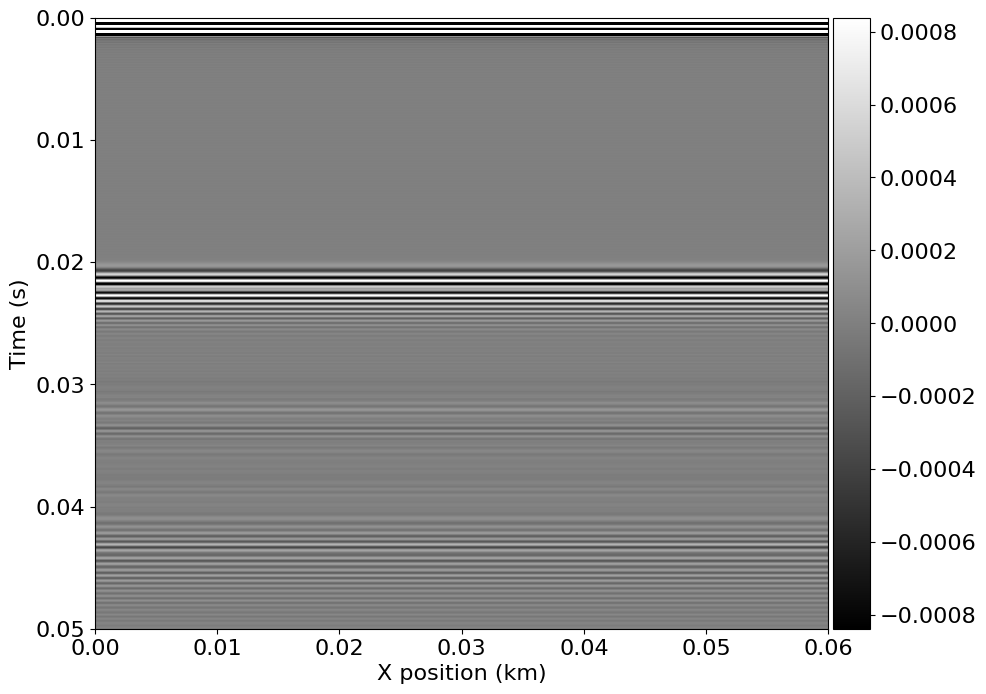

In [8]:
u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)
# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * model.critical_dt**2 / model.m)
rec_term = rec.interpolate(expr=u)

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
# Run the operator for `(nt-2)` time steps:
op(time=time_range.num - 2, dt=model.critical_dt)
print(time_range.num)
plot_shotrecord(rec.data, model, 0.0, 50)

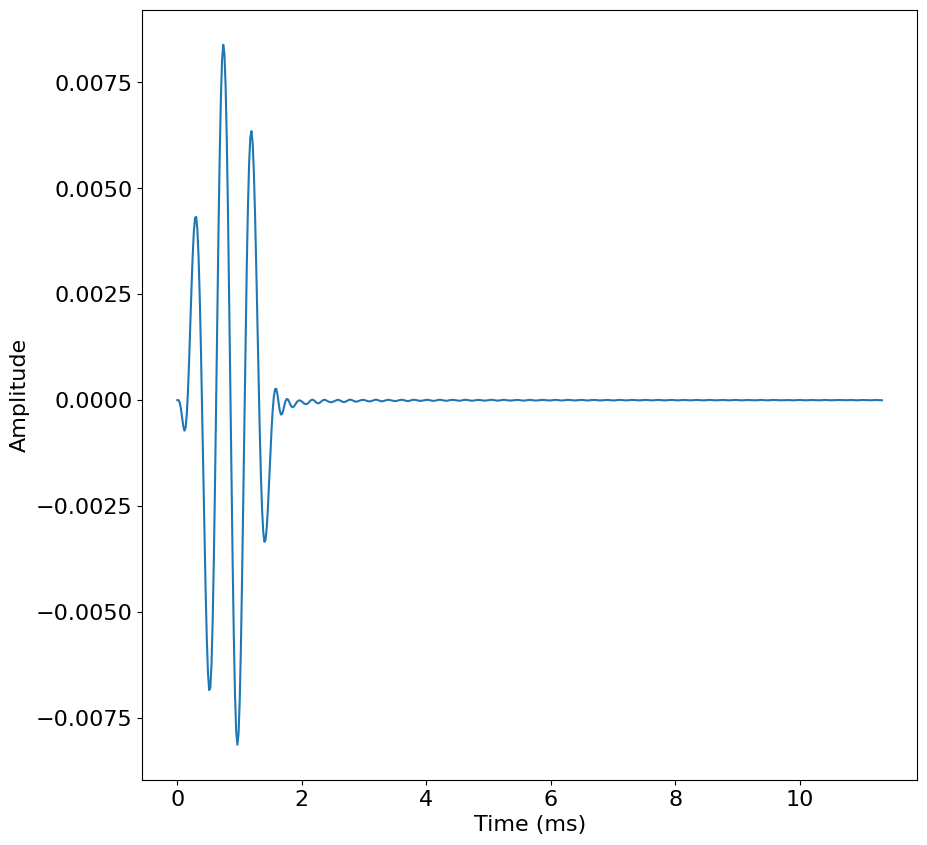

In [9]:
plt.figure()
plt.plot(src.time_values[:600],rec.data[:600,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

## Function for calculating the distance

In [10]:
def objDistance(receiver, timestep:float, v_env: float) -> Tuple[float, float]:
    cut = 600
    x = receiver[cut:]
    peaks, _ = find_peaks(x)
    prominences = peak_prominences(x, peaks)[0]
    first_peak = cut + peaks[(prominences - np.average(prominences)) > np.std(prominences)][0]
    distance = (((first_peak * timestep) / 2 ) * v_env)
    return distance, x[first_peak - cut]

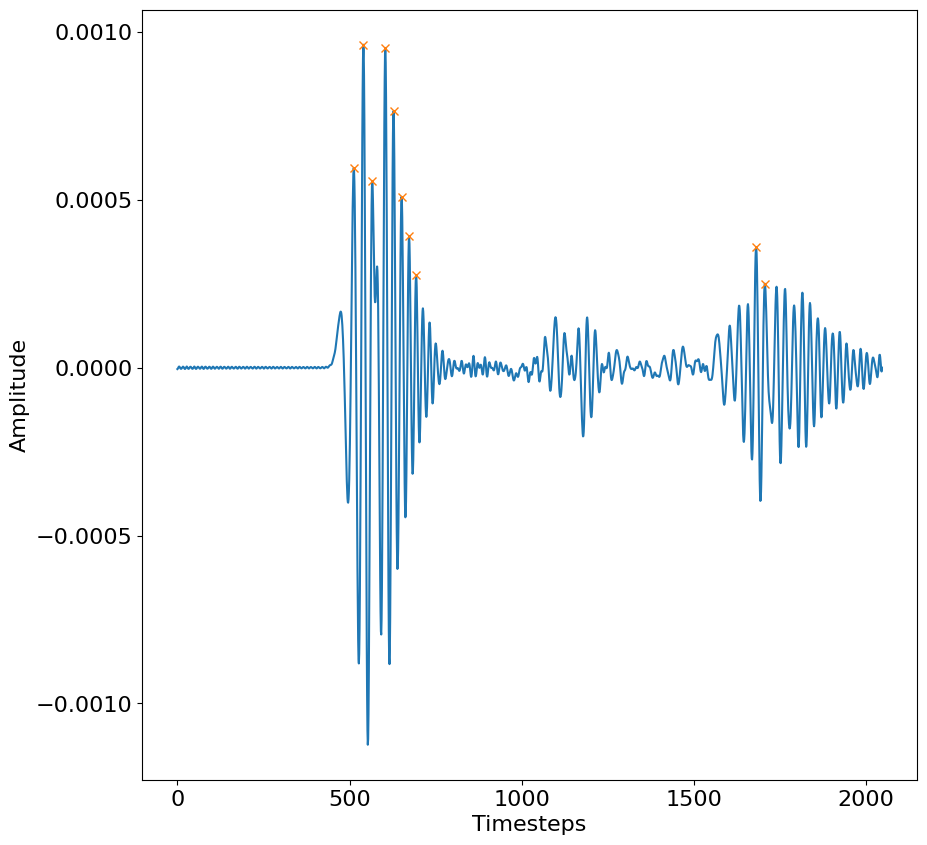

Amplitude of the first peak: 5.9402e-04


In [11]:
cut = 600
avg = np.average(rec.data, axis = 1)
x = avg[cut:]
peaks, _ = find_peaks(x)
prominences = peak_prominences(x, peaks)[0]
true_peaks= peaks[(prominences - np.average(prominences)) > np.std(prominences)]
plt.xlabel("Timesteps")
plt.ylabel("Amplitude")
plt.plot(x)
plt.plot(true_peaks, x[true_peaks], "x")
plt.show()
print(f"Amplitude of the first peak: {x[true_peaks][0]:.4e}")

In [12]:
print(objDistance(np.average(rec.data, axis = 1), model.critical_dt, v_water))

(15.762599632143974, 0.00059402204)


## Function for position/angle sweep

In [13]:
def run_positions_angles(model, src, rec, op, u, v_env, source_distance, time_range,
                          posx=[0.5], posy=[0.0], angle=[90]):
    if np.size(posx) != np.size(posy):
        print("error, posx and posy arrays must be same length")
        return
    distances = np.zeros((np.size(posx), np.size(angle)))
    amplitudes = np.zeros((np.size(posx), np.size(angle)))
    print(np.shape(distances))
    res = np.zeros((len(angle), rec.data.shape[0], rec.data.shape[1]))
    for i, (px, py) in enumerate(zip(posx, posy)):
        for j, alpha in enumerate(angle):
            start = time.time()

            pos, _ = srcPositionsInDomain(model.domain_size,
                                          posx=px,
                                          posy=py,
                                          angle=alpha,
                                          ns=src.coordinates.data.shape[0],
                                          source_distance=source_distance)
            src.coordinates.data[:] = pos[:]
            rec.coordinates.data[:] = pos[:]
            u.data.fill(0)

            # Run the operator for `(nt-2)` time steps:
            op(time=time_range.num - 2, dt=model.critical_dt)
            res[j] = rec.data
            result = objDistance(np.average(rec.data, axis=1),
                                 model.critical_dt, v_env)
            distances[i, j] = result[0]
            amplitudes[i, j] = result[1]
            print(f"Iteration took: {time.time() - start}")
    return distances, amplitudes, res


In [14]:
angles = np.arange(5, 175)
results = run_positions_angles(model, src, rec, op, u, v_water, source_distance,
                               time_range, posx=[0.5], posy=[0.5], angle=angles)
print(results)


(1, 170)


Operator `Kernel` ran in 1.59 s


Iteration took: 3.4612858295440674


Operator `Kernel` ran in 0.90 s


Iteration took: 1.9248592853546143


Operator `Kernel` ran in 1.06 s


Iteration took: 1.9220929145812988


Operator `Kernel` ran in 2.16 s


Iteration took: 3.267911911010742


Operator `Kernel` ran in 0.91 s


Iteration took: 2.411254644393921


Operator `Kernel` ran in 0.71 s


Iteration took: 1.515456199645996


Operator `Kernel` ran in 0.69 s


Iteration took: 1.4285922050476074


Operator `Kernel` ran in 0.80 s


Iteration took: 1.6602795124053955


Operator `Kernel` ran in 1.01 s


Iteration took: 1.7649900913238525


Operator `Kernel` ran in 1.30 s


Iteration took: 2.3507349491119385


Operator `Kernel` ran in 0.88 s


Iteration took: 1.827770709991455


Operator `Kernel` ran in 0.68 s


Iteration took: 1.4287664890289307


Operator `Kernel` ran in 0.62 s


Iteration took: 1.2721936702728271


Operator `Kernel` ran in 0.64 s


Iteration took: 1.2896575927734375


Operator `Kernel` ran in 0.90 s


Iteration took: 1.623462200164795


Operator `Kernel` ran in 0.88 s


Iteration took: 1.8270623683929443


Operator `Kernel` ran in 0.92 s


Iteration took: 1.925767183303833


Operator `Kernel` ran in 0.77 s


Iteration took: 1.6102793216705322


Operator `Kernel` ran in 0.68 s


Iteration took: 1.3327453136444092


Operator `Kernel` ran in 0.62 s


Iteration took: 1.264336347579956


Operator `Kernel` ran in 0.67 s


Iteration took: 1.3453733921051025


Operator `Kernel` ran in 0.84 s


Iteration took: 1.7893915176391602


Operator `Kernel` ran in 1.06 s


Iteration took: 1.927687406539917


Operator `Kernel` ran in 0.88 s


Iteration took: 1.7711119651794434


Operator `Kernel` ran in 0.65 s


Iteration took: 1.3143441677093506


Operator `Kernel` ran in 0.66 s


Iteration took: 1.3155405521392822


Operator `Kernel` ran in 0.66 s


Iteration took: 1.3095686435699463


Operator `Kernel` ran in 0.94 s


Iteration took: 1.6570320129394531


Operator `Kernel` ran in 0.79 s


Iteration took: 1.6312391757965088


Operator `Kernel` ran in 0.84 s


Iteration took: 1.9312753677368164


Operator `Kernel` ran in 0.64 s


Iteration took: 1.423762321472168


Operator `Kernel` ran in 0.63 s


Iteration took: 1.2763442993164062


Operator `Kernel` ran in 0.62 s


Iteration took: 1.2782373428344727


Operator `Kernel` ran in 0.71 s


Iteration took: 1.3740711212158203


Operator `Kernel` ran in 0.83 s


Iteration took: 1.7658984661102295


Operator `Kernel` ran in 1.64 s


Iteration took: 2.5053951740264893


Operator `Kernel` ran in 0.74 s


Iteration took: 1.4875884056091309


Operator `Kernel` ran in 0.63 s


Iteration took: 1.2836859226226807


Operator `Kernel` ran in 0.79 s


Iteration took: 1.4418179988861084


Operator `Kernel` ran in 0.74 s


Iteration took: 1.528855800628662


Operator `Kernel` ran in 0.97 s


Iteration took: 1.8876609802246094


Operator `Kernel` ran in 1.10 s


Iteration took: 1.9301366806030273


Operator `Kernel` ran in 0.75 s


Iteration took: 1.9052722454071045


Operator `Kernel` ran in 0.66 s


Iteration took: 1.3343844413757324


Operator `Kernel` ran in 0.65 s


Iteration took: 1.366267204284668


Operator `Kernel` ran in 0.73 s


Iteration took: 1.413407325744629


Operator `Kernel` ran in 0.99 s


Iteration took: 1.8869688510894775


Operator `Kernel` ran in 1.23 s


Iteration took: 2.1579692363739014


Operator `Kernel` ran in 0.97 s


Iteration took: 2.003565788269043


Operator `Kernel` ran in 0.64 s


Iteration took: 1.2919232845306396


Operator `Kernel` ran in 0.85 s


Iteration took: 1.563204050064087


Operator `Kernel` ran in 1.49 s


Iteration took: 2.854679584503174


Operator `Kernel` ran in 1.17 s


Iteration took: 2.3414993286132812


Operator `Kernel` ran in 1.27 s


Iteration took: 2.1241321563720703


Operator `Kernel` ran in 0.88 s


Iteration took: 1.6870908737182617


Operator `Kernel` ran in 0.68 s


Iteration took: 1.3563153743743896


Operator `Kernel` ran in 0.70 s


Iteration took: 1.3457095623016357


Operator `Kernel` ran in 0.86 s


Iteration took: 1.541168451309204


Operator `Kernel` ran in 1.04 s


Iteration took: 1.7883780002593994


Operator `Kernel` ran in 1.32 s


Iteration took: 2.170408248901367


Operator `Kernel` ran in 0.84 s


Iteration took: 1.6918928623199463


Operator `Kernel` ran in 0.69 s


Iteration took: 1.7392551898956299


Operator `Kernel` ran in 0.71 s


Iteration took: 1.3840246200561523


Operator `Kernel` ran in 0.74 s


Iteration took: 1.3993587493896484


Operator `Kernel` ran in 1.56 s


Iteration took: 2.4457459449768066


Operator `Kernel` ran in 1.22 s


Iteration took: 2.4301936626434326


Operator `Kernel` ran in 1.24 s


Iteration took: 2.129357099533081


Operator `Kernel` ran in 1.00 s


Iteration took: 1.8761231899261475


Operator `Kernel` ran in 0.65 s


Iteration took: 1.306567668914795


Operator `Kernel` ran in 0.87 s


Iteration took: 1.8317584991455078


Operator `Kernel` ran in 1.40 s


Iteration took: 2.216110944747925


Operator `Kernel` ran in 1.08 s


Iteration took: 1.993577003479004


Operator `Kernel` ran in 0.62 s


Iteration took: 1.3054625988006592


Operator `Kernel` ran in 0.70 s


Iteration took: 1.3800172805786133


Operator `Kernel` ran in 0.69 s


Iteration took: 1.3709704875946045


Operator `Kernel` ran in 1.00 s


Iteration took: 2.0415592193603516


Operator `Kernel` ran in 1.03 s


Iteration took: 2.036872148513794


Operator `Kernel` ran in 0.85 s


Iteration took: 1.644073724746704


Operator `Kernel` ran in 1.03 s


Iteration took: 1.8241970539093018


Operator `Kernel` ran in 0.82 s


Iteration took: 1.629495620727539


Operator `Kernel` ran in 1.10 s


Iteration took: 1.874157428741455


Operator `Kernel` ran in 2.17 s


Iteration took: 3.2568533420562744


Operator `Kernel` ran in 0.90 s


Iteration took: 1.872798204421997


Operator `Kernel` ran in 0.78 s


Iteration took: 1.4485125541687012


Operator `Kernel` ran in 0.67 s


Iteration took: 1.414032220840454


Operator `Kernel` ran in 1.29 s


Iteration took: 2.1986265182495117


Operator `Kernel` ran in 1.52 s


Iteration took: 2.5065720081329346


Operator `Kernel` ran in 1.13 s


Iteration took: 2.056817054748535


Operator `Kernel` ran in 0.67 s


Iteration took: 1.361189365386963


Operator `Kernel` ran in 0.62 s


Iteration took: 1.302072286605835


Operator `Kernel` ran in 0.76 s


Iteration took: 1.4140160083770752


Operator `Kernel` ran in 0.96 s


Iteration took: 1.9417479038238525


Operator `Kernel` ran in 1.23 s


Iteration took: 2.133077621459961


Operator `Kernel` ran in 0.80 s


Iteration took: 1.5764575004577637


Operator `Kernel` ran in 0.69 s


Iteration took: 1.4042558670043945


Operator `Kernel` ran in 0.70 s


Iteration took: 1.4204356670379639


Operator `Kernel` ran in 0.71 s


Iteration took: 1.379227638244629


Operator `Kernel` ran in 0.92 s


Iteration took: 1.8922314643859863


Operator `Kernel` ran in 1.31 s


Iteration took: 2.0562515258789062


Operator `Kernel` ran in 0.81 s


Iteration took: 1.6267352104187012


Operator `Kernel` ran in 0.65 s


Iteration took: 1.3645801544189453


Operator `Kernel` ran in 0.70 s


Iteration took: 1.4021811485290527


Operator `Kernel` ran in 0.70 s


Iteration took: 1.3863916397094727


Operator `Kernel` ran in 1.64 s


Iteration took: 2.331508159637451


Operator `Kernel` ran in 1.13 s


Iteration took: 2.296867609024048


Operator `Kernel` ran in 0.85 s


Iteration took: 1.719123363494873


Operator `Kernel` ran in 0.72 s


Iteration took: 1.407344102859497


Operator `Kernel` ran in 0.98 s


Iteration took: 1.7154316902160645


Operator `Kernel` ran in 1.36 s


Iteration took: 2.244410276412964


Operator `Kernel` ran in 1.34 s


Iteration took: 2.1996753215789795


Operator `Kernel` ran in 0.80 s


Iteration took: 1.6406421661376953


Operator `Kernel` ran in 0.85 s


Iteration took: 1.5770444869995117


Operator `Kernel` ran in 0.71 s


Iteration took: 1.3824412822723389


Operator `Kernel` ran in 0.64 s


Iteration took: 1.3157596588134766


Operator `Kernel` ran in 0.99 s


Iteration took: 1.7654666900634766


Operator `Kernel` ran in 1.05 s


Iteration took: 1.964050054550171


Operator `Kernel` ran in 0.89 s


Iteration took: 1.7573859691619873


Operator `Kernel` ran in 0.67 s


Iteration took: 1.41513991355896


Operator `Kernel` ran in 0.66 s


Iteration took: 1.3377110958099365


Operator `Kernel` ran in 0.67 s


Iteration took: 1.3219633102416992


Operator `Kernel` ran in 0.78 s


Iteration took: 1.5764148235321045


Operator `Kernel` ran in 0.87 s


Iteration took: 1.696737289428711


Operator `Kernel` ran in 1.03 s


Iteration took: 2.000426769256592


Operator `Kernel` ran in 1.08 s


Iteration took: 1.8673524856567383


Operator `Kernel` ran in 0.65 s


Iteration took: 1.4141120910644531


Operator `Kernel` ran in 0.68 s


Iteration took: 1.3523876667022705


Operator `Kernel` ran in 0.89 s


Iteration took: 1.6601579189300537


Operator `Kernel` ran in 0.87 s


Iteration took: 1.739729642868042


Operator `Kernel` ran in 0.86 s


Iteration took: 1.878385305404663


Operator `Kernel` ran in 0.81 s


Iteration took: 1.6643893718719482


Operator `Kernel` ran in 0.69 s


Iteration took: 1.343794584274292


Operator `Kernel` ran in 0.67 s


Iteration took: 1.353184700012207


Operator `Kernel` ran in 0.81 s


Iteration took: 1.5848157405853271


Operator `Kernel` ran in 2.11 s


Iteration took: 3.551495313644409


Operator `Kernel` ran in 0.84 s


Iteration took: 1.6260929107666016


Operator `Kernel` ran in 0.62 s


Iteration took: 1.2880897521972656


Operator `Kernel` ran in 0.84 s


Iteration took: 1.5116803646087646


Operator `Kernel` ran in 0.71 s


Iteration took: 1.4911561012268066


Operator `Kernel` ran in 0.79 s


Iteration took: 1.5204250812530518


Operator `Kernel` ran in 0.73 s


Iteration took: 1.4756059646606445


Operator `Kernel` ran in 1.01 s


Iteration took: 1.7198400497436523


Operator `Kernel` ran in 1.12 s


Iteration took: 2.2318649291992188


Operator `Kernel` ran in 0.89 s


Iteration took: 1.635892629623413


Operator `Kernel` ran in 0.76 s


Iteration took: 1.5015089511871338


Operator `Kernel` ran in 0.64 s


Iteration took: 1.4147231578826904


Operator `Kernel` ran in 0.83 s


Iteration took: 1.638092041015625


Operator `Kernel` ran in 0.63 s


Iteration took: 1.2679011821746826


Operator `Kernel` ran in 0.62 s


Iteration took: 1.2726538181304932


Operator `Kernel` ran in 0.71 s


Iteration took: 1.5763514041900635


Operator `Kernel` ran in 1.09 s


Iteration took: 1.819129228591919


Operator `Kernel` ran in 0.77 s


Iteration took: 1.5411639213562012


Operator `Kernel` ran in 0.80 s


Iteration took: 1.5617563724517822


Operator `Kernel` ran in 0.69 s


Iteration took: 1.3279547691345215


Operator `Kernel` ran in 0.83 s


Iteration took: 1.509005069732666


Operator `Kernel` ran in 1.37 s


Iteration took: 2.1710901260375977


Operator `Kernel` ran in 0.86 s


Iteration took: 1.6487255096435547


Operator `Kernel` ran in 0.67 s


Iteration took: 1.3345239162445068


Operator `Kernel` ran in 0.97 s


Iteration took: 1.8997106552124023


Operator `Kernel` ran in 1.20 s


Iteration took: 2.062241792678833


Operator `Kernel` ran in 1.24 s


Iteration took: 2.1200754642486572


Operator `Kernel` ran in 0.86 s


Iteration took: 1.8204522132873535


Operator `Kernel` ran in 0.66 s


Iteration took: 1.5470938682556152


Operator `Kernel` ran in 0.66 s


Iteration took: 1.3404600620269775


Operator `Kernel` ran in 0.79 s


Iteration took: 1.5341196060180664


Operator `Kernel` ran in 0.85 s


Iteration took: 1.7356224060058594


Operator `Kernel` ran in 0.69 s


Iteration took: 1.3863410949707031


Operator `Kernel` ran in 0.69 s


Iteration took: 1.426534652709961


Operator `Kernel` ran in 1.43 s


Iteration took: 2.3696954250335693


Operator `Kernel` ran in 0.98 s


Iteration took: 1.8763983249664307


Operator `Kernel` ran in 0.66 s


Iteration took: 1.7142307758331299
(array([[15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.76259963, 15.76259963, 15.76259963, 15.76259963, 15.76259963,
        15.7625

## Function for returning the coordinates of the points

In [15]:
def calculate_coordinates(domain_size, rec_pos, angle=[65], distance=[26], amplitude=[2.3169e-09]):
    if np.size(amplitude) != np.size(distance):
        print("error, angle and distance arrays must be same length")
        return
    results = np.zeros((len(rec_pos), np.size(angle), 2))
    for i, pos in enumerate(rec_pos):
        for j, alpha in enumerate(angle):
            sx = pos[0]
            sy = pos[1]
            results[i, j,
                    0] = sx - np.cos(alpha * np.pi / 180) * distance[i, j]
            results[i, j,
                    1] = sy + np.sin(alpha * np.pi / 180) * distance[i, j]
    return results
            


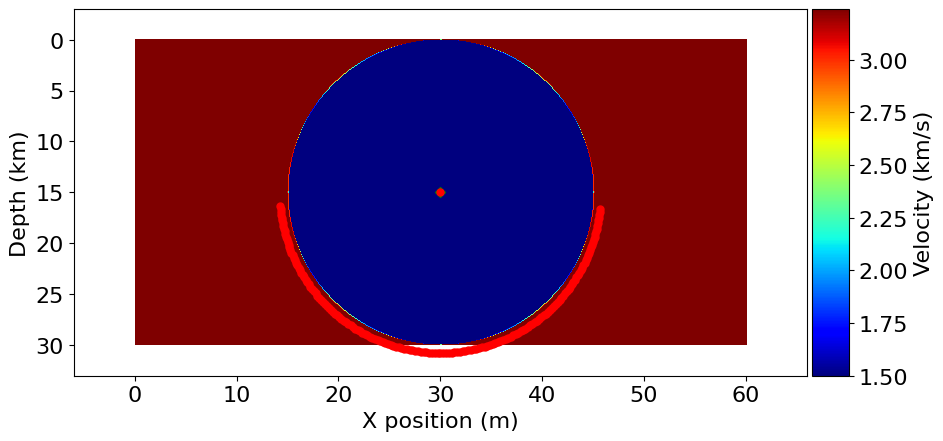

In [16]:
def compare_velocity_to_measure(model, result_coords, source=None, receiver=None,
                                colorbar=True, cmap="jet"):
    domain_size = np.array(model.domain_size)
    extent = [
        model.origin[0], model.origin[0] + domain_size[0],
        model.origin[1] + domain_size[1], model.origin[1]
    ]

    slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
    if getattr(model, 'vp', None) is not None:
        field = model.vp.data[slices]
    else:
        field = model.lam.data[slices]
    plot = plt.imshow(np.transpose(field),
                      animated=True,
                      cmap=cmap,
                      vmin=np.min(field),
                      vmax=np.max(field),
                      extent=extent)
    plt.xlabel('X position (m)')
    plt.ylabel('Depth (km)')

    # Plot source points, if provided
    if receiver is not None:
        plt.scatter(receiver[:, 0],
                    receiver[:, 1],
                    s=25,
                    c='green',
                    marker='D')

    # Plot receiver points, if provided
    if source is not None:
        plt.scatter(source[:, 0], source[:, 1], s=25, c='red', marker='o')
    plt.scatter(result_coords[:, 0],
                result_coords[:, 1],
                s=25,
                c='red',
                marker='o')

    # Ensure axis limits
    plt.xlim(model.origin[0] - domain_size[0] * 0.1,
             model.origin[0] + domain_size[0] * 1.1)
    plt.ylim(model.origin[1] + domain_size[1] * 1.1,
             model.origin[1] - domain_size[1] * 0.1)

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(plot, cax=cax)
        cbar.set_label('Velocity (km/s)')
    plt.show()


res2 = calculate_coordinates(model.domain_size, rec_pos=[center_pos], angle=angles,
                             distance=results[0], amplitude=results[1])

compare_velocity_to_measure(model, res2[0], source=src.coordinates.data, receiver=rec.coordinates.data)

